In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False

class Lego_Phases():
    
    IMG_S = 100
    
    PHASE_1 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_1"
    PHASE_2 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_2"
    PHASE_3 = "E:/Egyetem/5_felev/Temalab/lego_errors/phase_3"

    #TESTING ? 
    LABELS = {PHASE_1: 0, PHASE_2: 1, PHASE_3: 2}
    
    training_data= []
    
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_COLOR)
                        img = cv2.resize(img, (self.IMG_S, self.IMG_S))
                        self.training_data.append([np.array(img), np.eye(3)[self.LABELS[label]]]) # állapotszám beáll.

                                
                    except Exception as e:
                        pass
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        
if REBUILD_DATA:
    legophases = Lego_Phases()
    legophases.make_training_data()


100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [02:20<00:00,  4.16it/s]


In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

1408


In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(3, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        #random adat
        x = torch.randn(100,100,3).view(-1,3,100,100)
        self._to_linear = None
        self.convs(x) #átküldjük
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 3) #itt az osztályok száma
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [8]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [9]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,3,100,100)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [10]:
VAL_PCT = 0.2
val_size = int(len(X)*VAL_PCT)
print(val_size)

281


In [11]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

1127 281


In [12]:
BATCH_SIZE = 50
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 100, 100)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.22221212089061737


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.22181478142738342


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.19083614647388458


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.192692831158638


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.1699366569519043


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.14862412214279175


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.17738422751426697


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.17130328714847565


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.14181986451148987


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.15s/it]

Epoch: 9. Loss: 0.10867289453744888


In [19]:
y_pred = []
y_test = []

bad_dec = []
real = []
bad_num = 0
bad_pics = []

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 3, 100, 100))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)
        
        y_pred.append(predicted_class)
        y_test.append(real_class)
        
        if predicted_class == real_class:
            correct += 1
        else:
            bad_num += 1
            bad_dec.append(predicted_class)
            real.append(real_class)
            bad_pics.append(test_X[i])
            #print(plt.imshow(test_X[i].reshape(100,100,3)))
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [00:03<00:00, 80.09it/s]

Accuracy:  0.73


In [1]:
#teszt alapján adott rossz válaszok

from matplotlib.pyplot import imshow, show    


#for i in range(bad_num):
    #print("Valos: ", real[i].item(), ", tippelt: ", bad_dec[i].item())
    #plt.imshow(bad_pics[i].reshape(100,100,3))
    #show()

In [21]:
#confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[75, 13, 11],
       [19, 66,  9],
       [15,  9, 64]], dtype=int64)

Text(69.0, 0.5, 'Truth')

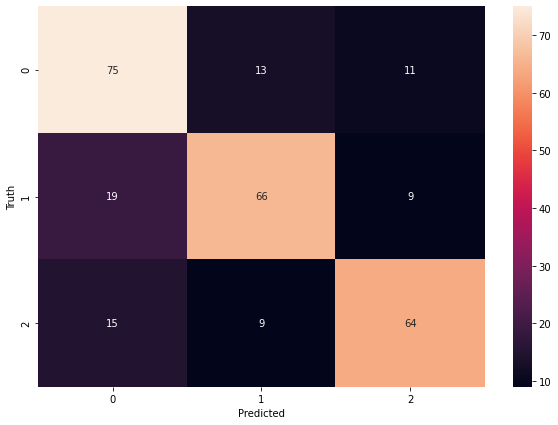

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')